In [1]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 194kB 8.2MB/s 
     |████████████████████████████████| 112kB 16.2MB/s 
     |████████████████████████████████| 245kB 8.9MB/s 
     |████████████████████████████████| 2.2MB 8.0MB/s 
     |████████████████████████████████| 870kB 21.1MB/s 
     |████████████████████████████████| 3.3MB 49.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=70575af0aea3c97fb553915348dafb6903faef784c972dca9f736e5c7e8fb9c9
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [2]:
from datasets import load_dataset
data = load_dataset(
   'tweets_hate_speech_detection') #загружаем датасет

Using custom data configuration default


Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0. Subsequent calls will reuse this data.


In [3]:
import pandas as pd
import numpy as np
import torch
import random
import os
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from tqdm import tqdm, tqdm_notebook
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

In [5]:
df = pd.DataFrame(data["train"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa99ac53b90>]],
      dtype=object)

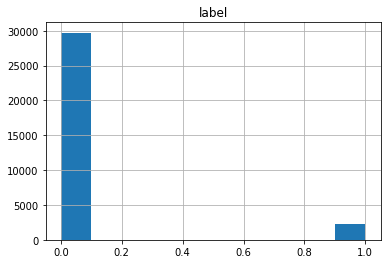

In [6]:
df.hist() #распределение классов в датасете

Создадим наивный классификатор, который всегда предсказывает самый распространенный класс, чтобы сравнивать accuracy модели RoBERTa с его accuracy

In [8]:
def naive_baseline(X):
  return np.zeros((X.shape[0], 1))

In [9]:
naive_y = naive_baseline(df)

In [10]:
accuracy_score(df.label, naive_y)

0.9298542018647143

Подготовим тренировочные, тестовые и валидационные данные

In [12]:
X, y = df.drop('label', axis=1), df.label

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)

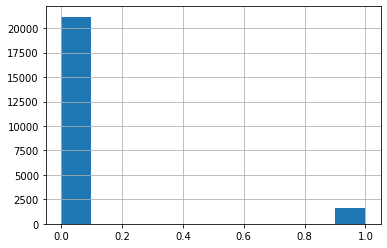

In [14]:
y_train.hist()

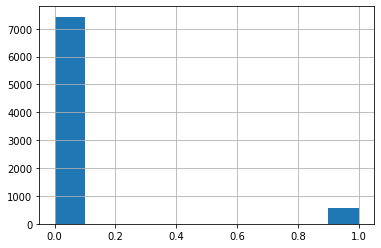

In [15]:
y_test.hist()

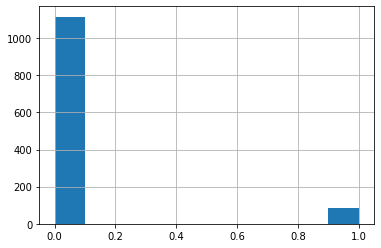

In [16]:
y_val.hist()

In [17]:
naive_y_test = naive_baseline(X_test)

In [18]:
accuracy_score(y_test, naive_y_test)

0.9297960205230885

Я пытался применить оверсэмплинг менее распространенного класса, используя аугментацию с помощью BERT, но это не помогло улучшить качество финальной модели

In [ ]:
#!pip install nlpaug

     |████████████████████████████████| 399kB 8.2MB/s 


In [ ]:
#import nlpaug.augmenter.word as naw

In [ ]:
#aug = naw.ContextualWordEmbsAug(model_path='google/bert_uncased_L-2_H-128_A-2', action="substitute")

In [ ]:
#aug.augment("@user @user you don't have the balls to hashtag me as a  but you say i am to weasel away.. lumpy tony.. dipshit.")

"@ and @ user if you'b have the keys can distract me as a but you say i am to it says.. lumpy is.. dipshit."

In [ ]:
#def resample_aug(X, y, oversample, to_numpy=True):
#  X, y = np.array(X['tweet']), np.array(y)
#  indices_over = np.where(y == 1)[0]
#  for i in range(int(oversample)):
#    print(i)
#    X_aug = X[indices_over]
#    y_aug = np.ones(indices_over.shape[0])
#    for j in range(indices_over.shape[0] // 128):
#      augs = aug.augment(list(X_aug[128 * j : 128 * j + 128]))
#      print(augs)
#      X = np.hstack((X, augs))
#      y = np.hstack((y, y_aug[128 * j : 128 * j + 128]))
#      print(y_aug[128 * j : 128 * j + 128])
#  if to_numpy == False:
#    return pd.DataFrame(X), pd.DataFrame(y)
#  else:
#    return X, y

In [ ]:
#augs = aug.augment(list(np.array(X_train['tweet'])[np.where(y_train == 1)[0]][0:128]))

In [ ]:
#X_train_resampled, y_train_resampled = resample_aug(X_train, y_train, oversample=5, to_numpy=False)

0
['@ user in # pueorico, # 89 release and his label reached # coal records : 1996', '@ me and stop crying " it screamed " and you be cornered and no last reason to offer. trust me read a button! it …', 'a girl at me repug gop pay # bigots and', 'i want to meet for the rest of all, b / c even one else alone, b / c is this only racist bullying anyone outside of', "@ user # 14 # cnn # 16 of williams :'they want that the'trump for unmasking america'’", 'him replies. is dead tho. you', '@ user # 4 # 25 # us # 21 # you # 2 # 2 # your # 3 # parents for is # 41 # massive # amounts # of march 2016.', 'ever played a much scum # it hires?', 'video men and participate in a without clothes candid videos of', '( only ) black on which also be affiliated with very suppoed by three world pay and other european people', '@ the # allahsoil the only a factor. how terrorisma provides a human action to capitalism revolution. communism.', "he's already happening @ user @ google had won # russia more reasons

Приведем данные к допустимому для входа модели виду используя предобученный токенизатор

In [18]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [19]:
#X_tokenized = tokenizer(X_train_resampled[0].tolist(), padding='max_length', return_tensors="pt")
X_tokenized = tokenizer(X_train['tweet'].tolist(), padding='max_length', return_tensors="pt")
X_val_tokenized = tokenizer(X_val['tweet'].tolist(), padding='max_length', return_tensors="pt")
X_test_tokenized = tokenizer(X_test['tweet'].tolist(), padding='max_length', return_tensors="pt")

In [20]:
X_test_tokenized['input_ids'].shape

torch.Size([7991, 512])

Загрузим предобученную модель

In [21]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', return_dict=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [22]:
DEVICE = torch.device("cuda")
use_gpu = True
batch_size = 16

In [23]:
train_dataset = torch.utils.data.TensorDataset(X_tokenized['input_ids'], 
                                               X_tokenized['attention_mask'], 
                                               #torch.tensor(y_train_resampled.to_numpy().flatten()))
                                                torch.tensor(y_train.to_numpy().flatten()))
val_dataset = torch.utils.data.TensorDataset(X_val_tokenized['input_ids'], 
                                             X_val_tokenized['attention_mask'],
                                             torch.tensor(y_val.to_numpy().flatten()))
test_dataset = torch.utils.data.TensorDataset(X_test_tokenized['input_ids'], 
                                             X_test_tokenized['attention_mask'])

In [24]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Я пробовал обучать только классификатор, замораживая веса энкодера, но качество модели от этого ухудшилось

In [ ]:
#for param in model.base_model.parameters():
    #param.requires_grad = False

Обучим модель

In [26]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, masks, labels in train_loader:
        inputs = inputs.to(DEVICE)
        masks = masks.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(input_ids=inputs, attention_mask=masks)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        preds = torch.argmax(outputs, 1)
        #_, preds = torch.max(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [27]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, masks, labels in val_loader:
        inputs = inputs.to(DEVICE)
        masks = masks.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(input_ids=inputs, attention_mask=masks)[0]
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            #_, preds = torch.max(outputs, dim=1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [28]:
def train(train_loader, val_loader, model, epochs, batch_size):

    

    #dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=0, num_training_steps=total_steps)
        #opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            #scheduler.step(val_loss)
            
    return history

In [29]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs, masks in test_loader:
            inputs = inputs.to(DEVICE)
            masks = masks.to(DEVICE)
            model.eval()
            outputs = model(input_ids=inputs, attention_mask=masks)[0].cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [30]:
history = train(train_loader, val_loader, model=model.to(DEVICE), epochs=5, batch_size=batch_size)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.2565259171491785


epoch:  20%|██        | 1/5 [33:57<2:15:50, 2037.68s/it]


Epoch 001 train_loss: 0.2565     val_loss 0.2543 train_acc 0.9299 val_acc 0.9299
loss 0.24972717800640104


epoch:  40%|████      | 2/5 [1:07:57<1:41:55, 2038.38s/it]


Epoch 002 train_loss: 0.2497     val_loss 0.1910 train_acc 0.9293 val_acc 0.9299
loss 0.1616093436043056


epoch:  60%|██████    | 3/5 [1:41:58<1:07:58, 2039.14s/it]


Epoch 003 train_loss: 0.1616     val_loss 0.0877 train_acc 0.9426 val_acc 0.9675
loss 0.08480090795674743


epoch:  80%|████████  | 4/5 [2:15:59<33:59, 2039.64s/it]


Epoch 004 train_loss: 0.0848     val_loss 0.0764 train_acc 0.9708 val_acc 0.9725
loss 0.060792962200995275


epoch: 100%|██████████| 5/5 [2:49:53<00:00, 2038.74s/it]


Epoch 005 train_loss: 0.0608     val_loss 0.0694 train_acc 0.9802 val_acc 0.9775


График изменения accuracy в зависимости от эпохи обучения.
На нем мы видим, что точность росла, а значительного переобучения не произошло

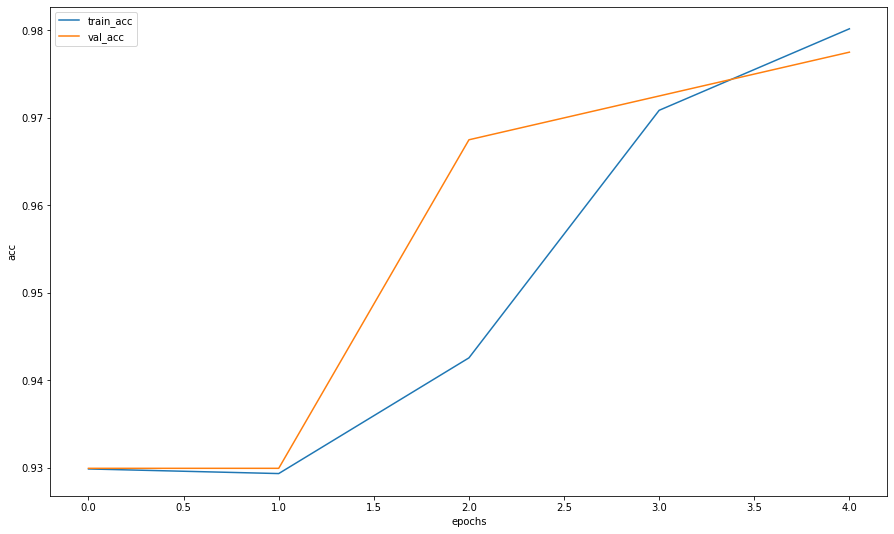

In [31]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [47]:
torch.save(model.state_dict(), '/content/drive/MyDrive/RoBERTa_nofreeze.pth')

In [50]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/RoBERTa_nofreeze.pth'))

<All keys matched successfully>

In [ ]:
#model = model.to(DEVICE)

Оценим качество модели на тестовом множестве

In [51]:
y_prob = predict(model, test_loader)

In [52]:
y_pred = np.argmax(y_prob, axis=1)

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[7342   88]
 [ 135  426]]


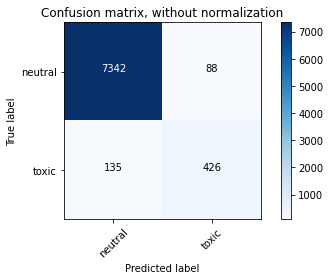

In [55]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['neutral', 'toxic'],
                      title='Confusion matrix, without normalization')

In [56]:
accuracy_score(y_test, y_pred)

0.9720936053059692

In [58]:
roc_auc_score(y_test, y_prob[:, 1])

0.9809318343757423

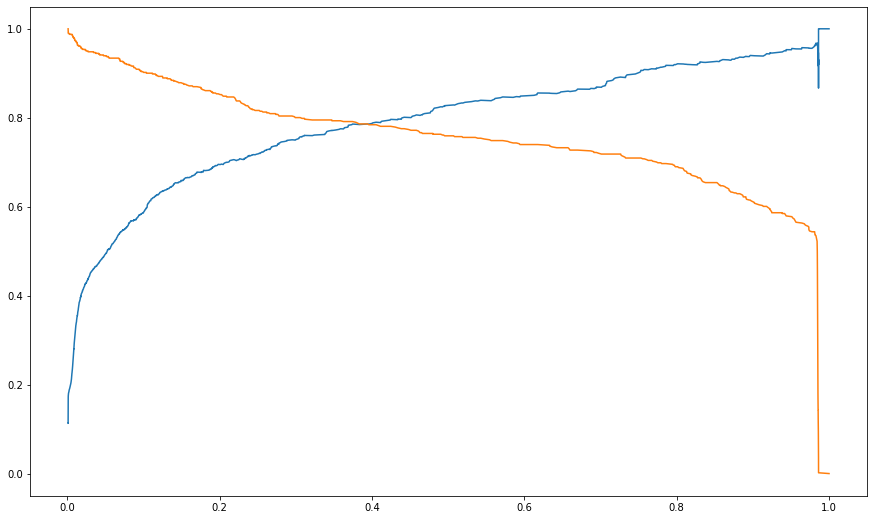

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])
thresholds = np.append(thresholds, 1)
plt.figure(figsize=(15, 9))
plt.plot(thresholds, precision, label="precision")
plt.plot(thresholds, recall, label="recall")

In [60]:
def classify(probs, threshold):
  return (probs[:, 1] > threshold).astype(np.int)

In [61]:
y_pred_thr = classify(y_prob, 0.4)

Confusion matrix, without normalization
[[7312  118]
 [ 121  440]]


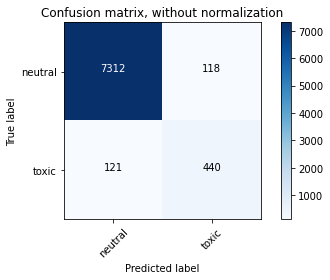

In [45]:
cnf_matrix = confusion_matrix(y_test, y_pred_thr, labels=[0, 1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['neutral', 'toxic'],
                      title='Confusion matrix, without normalization')

In [46]:
accuracy_score(y_test, y_pred_thr)

0.9700913527718683

Итак, я получил модель, которая значительно превосходит наивный классификатор по accuracy, по ROC AUC модель тоже показывает хорошее качество. Используя график Precision-Recall, я подобрал оптимальный с точки зрения того, чтобы и precision, и recall были максимальными, порог классификации (~0.4), однако accuracy при этом несколько упала (вероятно, из-за значительного дисбаланса классов).